In [108]:
"""
Description: Get current currency rates from ECB.
Author: Richard van Wijk
Date: 18-10-2020
Maintainer: Richard van Wijk
Email: vanwijk@ducata.com
Status: Dev
"""
from currency_converter import CurrencyConverter
from datetime import timedelta, date, datetime
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Set notebook options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 43)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', 15)
pd.set_option('display.precision', 3)

In [166]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def create_original_df(base_currency="EUR"):
    """Create the original dataframe based on ECB data.
   
    Parameters
    ----------
    base_currency : str
        The currency that is used to express other currency exchange rates."""
    c = CurrencyConverter("http://www.ecb.int/stats/eurofxref/eurofxref-hist.zip", 
                          fallback_on_wrong_date=True, 
                          fallback_on_missing_rate=True,
                          decimal=True)

    start_date = date(2000, 1, 1)
    end_date = date.today()

    date_list = []

    for single_date in daterange(start_date, end_date):

        cur_list = []
        cur_list.append(single_date)

        for currency in c.currencies:

            value = c.convert(1, base_currency, currency, date=single_date)
            cur_list.append(float(value))

        date_list.append(cur_list)

    columns_list = ["date"] + list(c.currencies)

    df = pd.DataFrame(date_list, columns=columns_list)
    df = df.sort_values(by="date", ascending=False)
    
    df["date"] = df["date"].map(lambda x: datetime(x.year, x.month, x.day))
    
    return df

In [112]:
# Define currencies of interest
currencies = ['USD','EUR','GBP',
              'CHF','CNY','JPY',
              'CAD','SEK','NOK',
              'SGD','AUD','NZD',
              'ZAR']

# Create dataframe with pre-defined base currency
df = create_original_df("EUR")

# Subset columns of interest
df = df[["date"]+currencies]

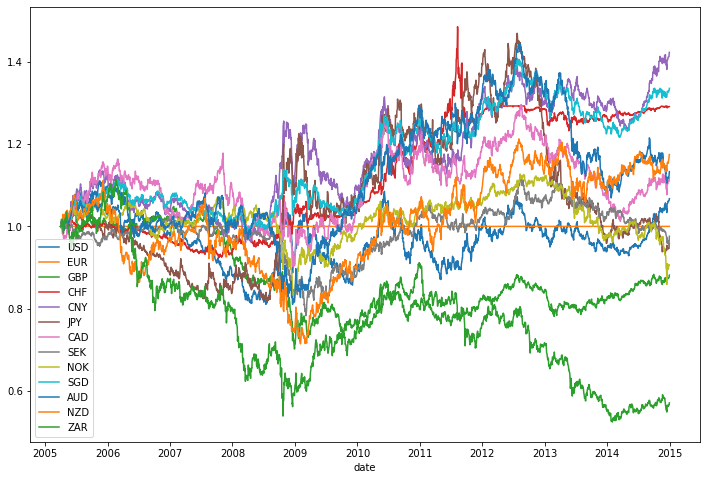

In [113]:
# Determine splits for dev- (train and test) and validation set
train_start = date(2005, 4, 1)
test_start = date(2012, 1, 1)
validation_start = date(2015, 1, 1)
validation_end = date(2020, 10, 1)

# Sort dataframe by date
df = df.sort_values("date").reset_index(drop=True)

# Create dev (train and test) and validation set
train = df.query("date >= @train_start and date < @test_start")
test = df.query("date >= @test_start and date < @validation_start")
dev = pd.concat([train, test])
val = df.query("date >= @validation_start and date < @validation_end")

# Define figure size
plt.figure(figsize=(12, 8))

for currency in currencies:
    plt.plot(dev["date"], 1/(dev[currency]/dev[currency].iloc[0]), label=currency)
#     plt.title(f"1 {currency} in EUR")
#     plt.ylabel(currency)
    plt.xlabel("date")
    
#     plt.ylim([0, 2/dev[currency].iloc[-1]])

plt.legend();

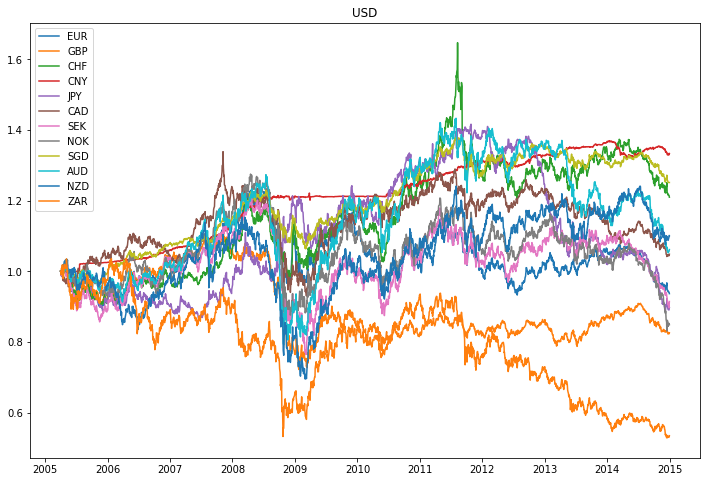

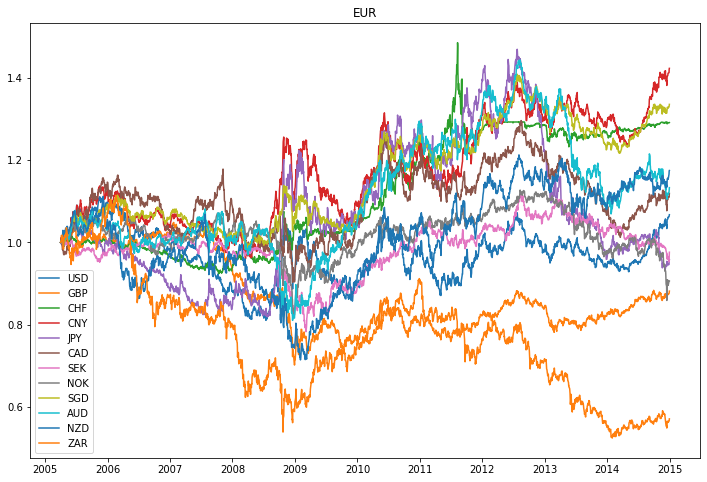

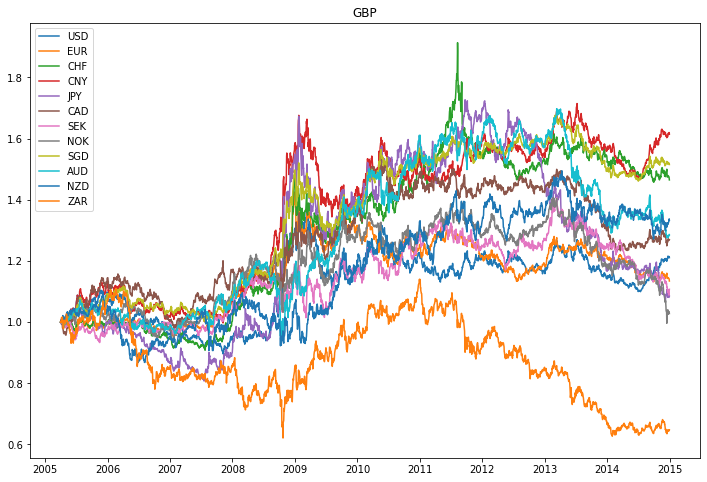

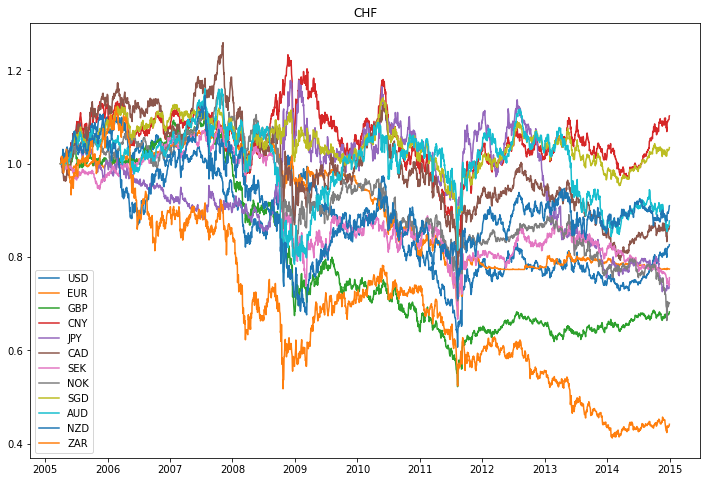

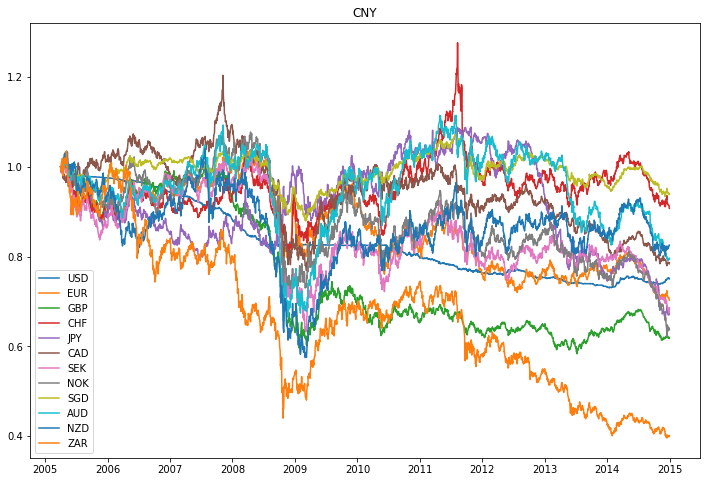

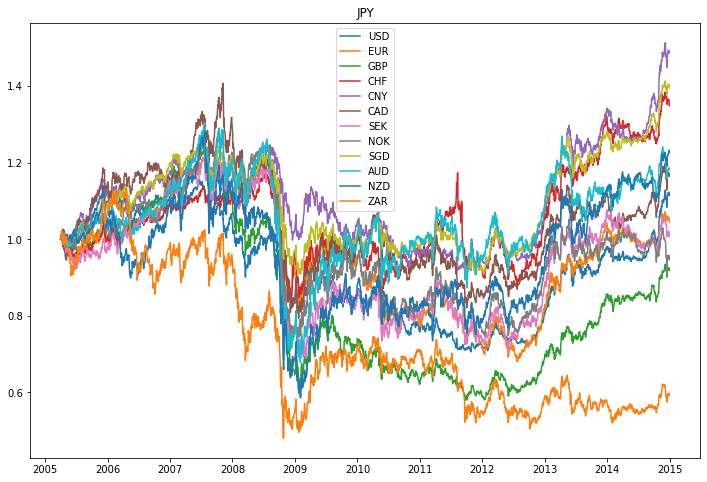

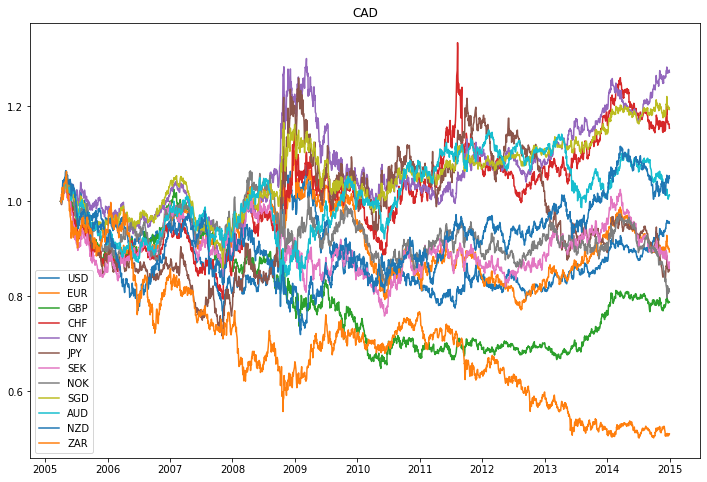

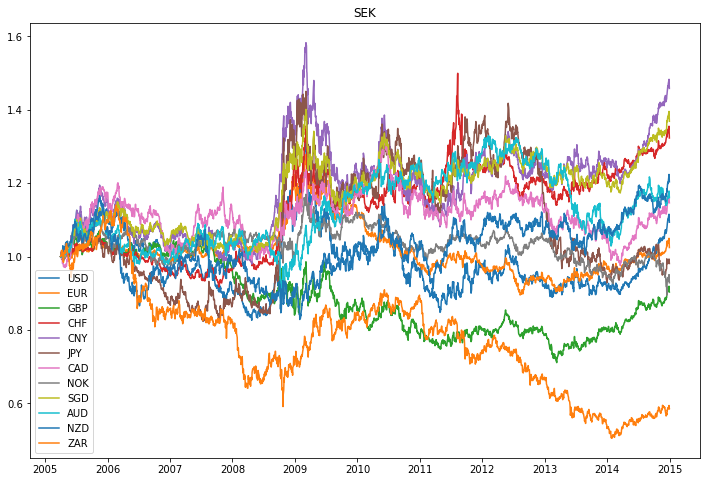

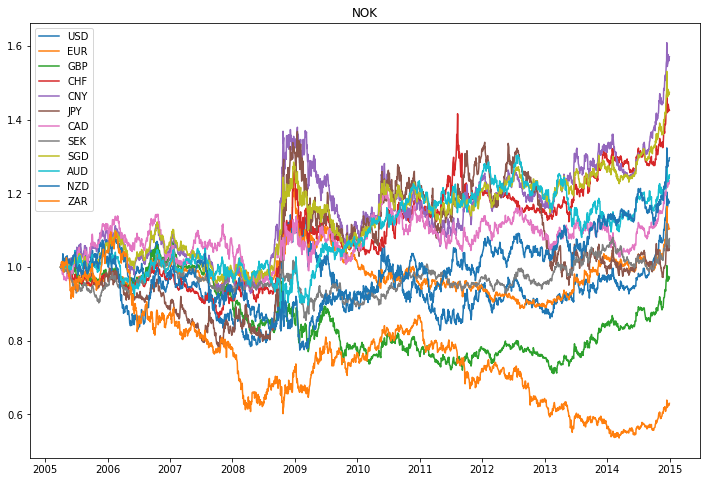

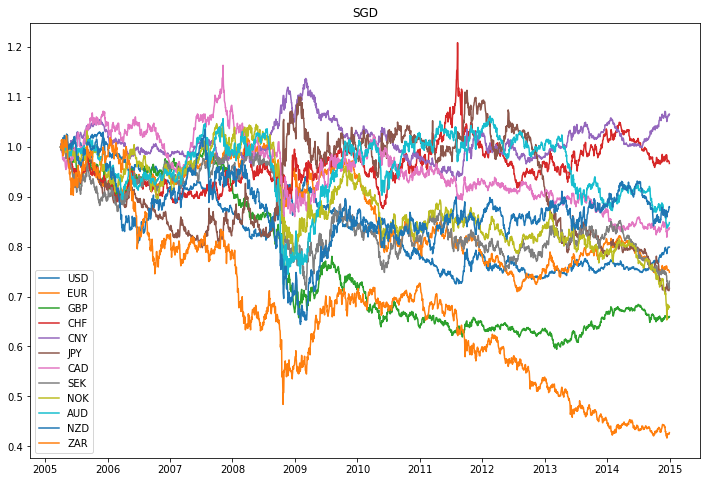

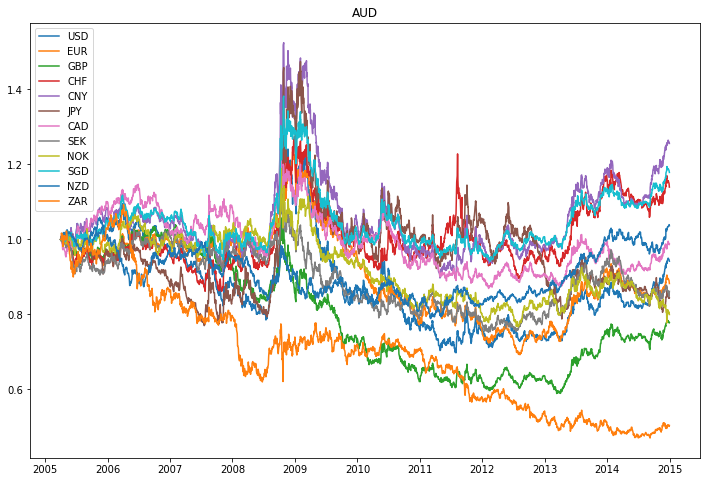

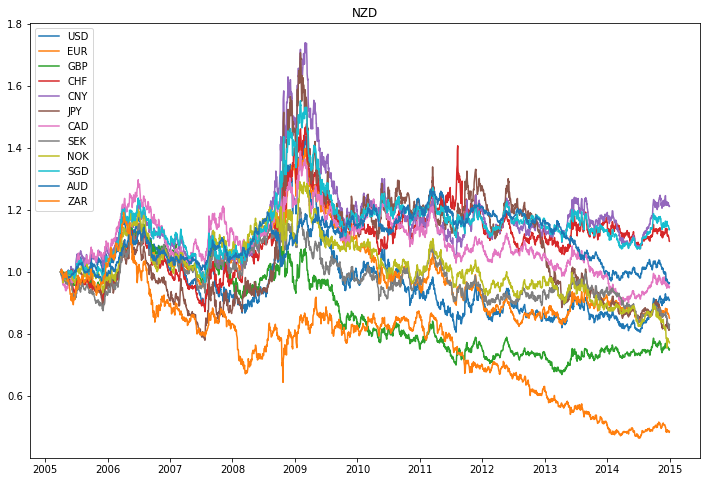

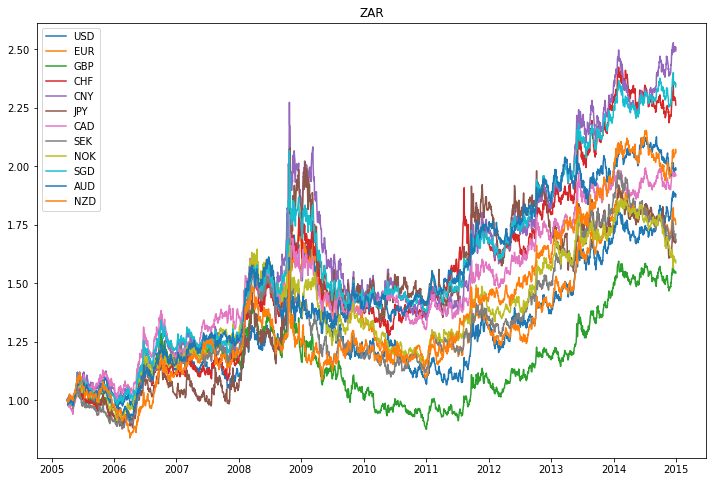

In [159]:
# Determine splits for dev- (train and test) and validation set
train_start = date(2005, 4, 1)
test_start = date(2012, 1, 1)
validation_start = date(2015, 1, 1)
validation_end = date(2020, 10, 1)

# Sort dataframe by date
df = df.sort_values("date").reset_index(drop=True)

# Create dev (train and test) and validation set
train = df.query("date >= @train_start and date < @test_start")
test = df.query("date >= @test_start and date < @validation_start")
dev = pd.concat([train, test])
val = df.query("date >= @validation_start and date < @validation_end")

for base_currency in currencies:
    plt.figure(figsize=(12, 8))
    plt.title(base_currency)
    
    for currency in currencies:
        if currency == base_currency:
            continue
            
        rates = dev[base_currency] / dev[currency]
        normalized_rates = rates / rates.iloc[0]
        
        plt.plot(dev["date"], normalized_rates, label=currency)
    
    plt.legend()

,loss_function_score
currency,
ZAR,0.152
GBP,0.058
CNY,0.031
EUR,0.025
USD,0.025
SGD,0.025
JPY,0.023
SEK,0.023
CHF,0.020


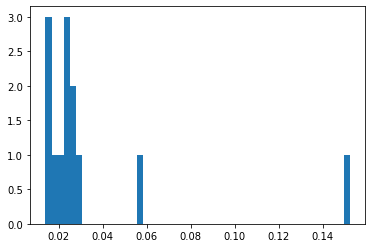

In [162]:
results = pd.DataFrame()

# Calculate loss function score per currency
for base_currency in currencies:
    for currency in currencies:
        if currency == base_currency:
            continue
            
        rates = dev[base_currency] / dev[currency]
        normalized_rates = rates / rates.iloc[0]
        
        deviation = np.log(normalized_rates)
        loss_function_score = (deviation**2).mean()

        results = results.append({"currency": currency,
                                  "base_currency": base_currency,
                                  "loss_function_score": loss_function_score},
                                 ignore_index=True)
    
results = results.groupby("currency").median()
plt.hist(results["loss_function_score"], bins=50)
results.sort_values("loss_function_score", ascending=False)
# results.query("base_currency == 'ZAR'")



In [155]:
base_currency = "CNY"
currency = "ZAR"

# base_currency = "ZAR"
# currency = "CNY"

rates = dev[base_currency] / dev[currency]
normalized_rates = rates / rates.iloc[0]

import numpy as np
np.log10(normalized_rates)

1917    0.000e+00
1918   -5.769e-04
1919   -1.155e-03
1920   -1.735e-03
1921   -4.349e-03
          ...    
5474   -3.983e-01
5475   -3.978e-01
5476   -3.973e-01
5477   -3.998e-01
5478   -3.968e-01
Length: 3562, dtype: float64

In [139]:
results = pd.DataFrame()

# Calculate loss function score per currency
for base_currency in ["EUR"]:
    for currency in currencies:
        if currency == base_currency:
            continue
            
        rates = dev[base_currency] / dev[currency]
        normalized_rates = rates / rates.iloc[0]
        
        deviation = normalized_rates - 1
        loss_function_score = (deviation**2).mean()

        results = results.append({"currency": currency,
                                  "base_currency": base_currency,
                                  "loss_function_score": loss_function_score},
                                 ignore_index=True)
    
results = results.groupby("currency").median()
results.sort_values("loss_function_score", ascending=False)

,loss_function_score
currency,
ZAR,0.074
CNY,0.044
SGD,0.040
CHF,0.033
AUD,0.032
JPY,0.031
GBP,0.025
CAD,0.016
NZD,0.013


In [132]:
dev["USD"] / dev["NOK"]

1917    0.158
1918    0.158
1919    0.157
1920    0.157
1921    0.157
        ...  
5474    0.134
5475    0.135
5476    0.135
5477    0.134
5478    0.134
Length: 3562, dtype: float64

In [240]:
# Function to retrieve historical currency data from yfinance
def download_currency_data(currency, base_currency="USD"):
    """Download currency data for pre-specified currency by using yfinance.
   
    Parameters
    ----------
    currency : str
        The currency of interest."""
    result = (yf.download(f"{base_currency}{currency}=X", start="2004-04-01", end="2014-12-31")[["Close"]]
                .reset_index()
                .rename(columns={"Close": currency, 
                                 "Date": "date"}))
                
    result["date"] = result["date"].map(pd.Timestamp.to_datetime64)
    
    return result.set_index("date")

In [246]:
result["date"].map(pd.Timestamp.to_datetime64)

type(result["date"].map(pd.Timestamp.to_datetime64)[0])

pandas._libs.tslibs.timestamps.Timestamp

In [241]:
base_currency = "EUR"
currency = "USD"

result = (yf.download(f"{base_currency}{currency}=X", start="2004-04-01", end="2014-12-31")[["Close"]]
                .reset_index()
                .rename(columns={"Close": currency, 
                                 "Date": "date"}))

[*********************100%***********************]  1 of 1 completed


In [242]:
type(download_currency_data("USD", "EUR").index[0])

[*********************100%***********************]  1 of 1 completed


pandas._libs.tslibs.timestamps.Timestamp

In [205]:
yfinance_data = pd.concat([download_currency_data(currency, "EUR") for currency in currencies if currency != "EUR"], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [206]:
yfinance_data

,USD,GBP,CHF,CNY,JPY,CAD,SEK,NOK,SGD,AUD,NZD,ZAR
date,,,,,,,,,,,,
2004-04-01,1.237,0.666,1.561,10.179,128.250,1.616,9.230,8.432,2.064,1.612,1.850,7.783
2004-04-02,1.213,0.663,1.565,10.021,126.850,1.593,9.226,8.392,2.032,1.579,1.839,7.716
2004-04-05,1.201,0.658,1.566,9.918,126.220,1.578,9.192,8.361,2.017,1.594,1.843,7.689
2004-04-06,1.213,0.658,1.559,9.987,128.250,1.590,9.210,8.385,2.041,1.591,1.848,7.649
2004-04-07,1.217,0.661,1.554,10.055,127.990,1.594,9.172,8.356,2.037,1.588,1.844,7.666
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-25,1.220,0.784,1.202,7.570,146.760,1.417,9.519,9.077,1.613,1.503,1.577,14.189
2014-12-26,1.221,0.784,1.202,7.575,146.920,1.418,9.480,9.085,1.614,1.505,1.578,14.165
2014-12-29,1.217,0.782,1.203,7.575,146.534,1.415,9.531,9.082,1.610,1.500,1.570,14.087


In [207]:
dev - yfinance_data

,AUD,CAD,CHF,CNY,EUR,GBP,JPY,NOK,NZD,SEK,SGD,USD,ZAR
date,,,,,,,,,,,,,
2004-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-29,-0.003,0.003,9.998e-05,0.017,NaN,0.002,0.426,-0.035,-5.500e-03,0.092,3.220e-03,2.755e-03,0.068


In [192]:
yfinance_data

,USD,GBP,CHF,CNY,JPY,CAD,SEK,NOK,SGD,AUD,NZD,ZAR
date,,,,,,,,,,,,
2004-04-01,1.237,0.666,1.561,10.179,128.250,1.616,9.230,8.432,2.064,1.612,1.850,7.783
2004-04-02,1.213,0.663,1.565,10.021,126.850,1.593,9.226,8.392,2.032,1.579,1.839,7.716
2004-04-05,1.201,0.658,1.566,9.918,126.220,1.578,9.192,8.361,2.017,1.594,1.843,7.689
2004-04-06,1.213,0.658,1.559,9.987,128.250,1.590,9.210,8.385,2.041,1.591,1.848,7.649
2004-04-07,1.217,0.661,1.554,10.055,127.990,1.594,9.172,8.356,2.037,1.588,1.844,7.666
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-25,1.220,0.784,1.202,7.570,146.760,1.417,9.519,9.077,1.613,1.503,1.577,14.189
2014-12-26,1.221,0.784,1.202,7.575,146.920,1.418,9.480,9.085,1.614,1.505,1.578,14.165
2014-12-29,1.217,0.782,1.203,7.575,146.534,1.415,9.531,9.082,1.610,1.500,1.570,14.087


In [210]:
# [i for i in dev.index if i not in list(yfinance_data.index)]

In [209]:
[i for i in yfinance_data.index if i not in list(dev.index)]

[Timestamp('2004-04-01 00:00:00', freq='B'),
 Timestamp('2004-04-02 00:00:00', freq='B'),
 Timestamp('2004-04-05 00:00:00', freq='B'),
 Timestamp('2004-04-06 00:00:00', freq='B'),
 Timestamp('2004-04-07 00:00:00', freq='B'),
 Timestamp('2004-04-08 00:00:00', freq='B'),
 Timestamp('2004-04-09 00:00:00', freq='B'),
 Timestamp('2004-04-12 00:00:00', freq='B'),
 Timestamp('2004-04-13 00:00:00', freq='B'),
 Timestamp('2004-04-14 00:00:00', freq='B'),
 Timestamp('2004-04-15 00:00:00', freq='B'),
 Timestamp('2004-04-16 00:00:00', freq='B'),
 Timestamp('2004-04-19 00:00:00', freq='B'),
 Timestamp('2004-04-20 00:00:00', freq='B'),
 Timestamp('2004-04-21 00:00:00', freq='B'),
 Timestamp('2004-04-22 00:00:00', freq='B'),
 Timestamp('2004-04-23 00:00:00', freq='B'),
 Timestamp('2004-04-26 00:00:00', freq='B'),
 Timestamp('2004-04-27 00:00:00', freq='B'),
 Timestamp('2004-04-28 00:00:00', freq='B'),
 Timestamp('2004-04-29 00:00:00', freq='B'),
 Timestamp('2004-04-30 00:00:00', freq='B'),
 Timestamp

In [167]:
curryfinance_dataR"

df_download = download_currency_data(currency)
df_usd = create_original_df("USD")[["date", currency]]

[*********************100%***********************]  1 of 1 completed


<ipython-input-124-b6573fa9d5b3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = df.index


In [130]:
df_usd.dtypes

date     object
ZAR     float64
dtype: object

In [129]:
df_download.dtypes

Date     datetime64[ns]
Close           float64
date     datetime64[ns]
dtype: object

In [127]:
df_download.merge(df_usd,
                  how="left",
                  on="date")

ValueError: You are trying to merge on datetime64[ns] and object columns. If you wish to proceed you should use pd.concat

In [165]:
df_usd["date"].map(lambda x: datetime(x.year, x.month, x.day)) 

7599   2020-10-21
7598   2020-10-20
7597   2020-10-19
7596   2020-10-18
7595   2020-10-17
          ...    
4      2000-01-05
3      2000-01-04
2      2000-01-03
1      2000-01-02
0      2000-01-01
Name: date, Length: 7600, dtype: datetime64[ns]